### Import libraries

In [1]:
import pandas as pd

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import numpy

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import requests # library to handle requests

# import k-means from clustering stage
from sklearn.cluster import KMeans

import seaborn

print('Libraries imported.')

pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

Libraries imported.


# 1. Get main dataframe

### Get metro coordinates (from Wikipedia)

In [2]:
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations')[1]

df['Year'] = df['Opened'].str.extract(pat = '^(\d\d\d\d)').astype("int")
df['Elev.'] = df['Elev.'].str.replace('−', '-')
df['Elevation'] = df['Elev.'].str.extract(pat = '^([\d+-.]+)').astype("float")
df['Latitude'] = df['Coordinates'].str.extract(pat = '/\s.([\d\.]+)').astype("float")
df['Longitude'] = df['Coordinates'].str.extract(pat = '([\d\.]+)°E$').astype("float")

df.drop(labels=['L', 'Opened', 'Elev.', 'Transfer', 'Coordinates', 'Pic.'], axis=1, inplace=True)
df.rename(columns={"English transcription": "Name"}, inplace=True)

# Fix wrong names
df.loc[df['Russian Cyrillic'] == 'Аэропорт', 'Name'] = "Aeroport"
df.loc[df['Russian Cyrillic'] == 'Алма-Атинская', 'Name'] = "Alma-Atinskaya"
df.loc[df['Russian Cyrillic'] == 'Бауманская', 'Name'] = "Baumanskaya"
df.loc[df['Russian Cyrillic'] == 'Александровский сад', 'Name'] = "Aleksandrovskiy sad"
df.loc[df['Russian Cyrillic'] == 'Алексеевская', 'Name'] = "Alekseevskaya"
df.loc[df['Russian Cyrillic'] == 'Академическая', 'Name'] = "Akademicheskaya"
df.loc[df['Russian Cyrillic'] == 'Алтуфьево', 'Name'] = "Altufievo"
df.loc[df['Russian Cyrillic'] == 'Аннино', 'Name'] = "Annino"

df = df.groupby('Name', as_index=False).agg({
    "Russian Cyrillic" : 'first',
    "Type" : 'first',
    "Year" : 'first',
    "Elevation" : 'first',
    "Latitude" : 'mean',
    "Longitude" : 'mean'  
})

df.head(10)

,Name,Russian Cyrillic,Type,Year,Elevation,Latitude,Longitude
0,Aeroport,Аэропорт,"single-vault, shallow",1938,-10.0,55.8003,37.5329
1,Akademicheskaya,Академическая,"column, triple-span",1962,-8.5,55.6877,37.5733
2,Aleksandrovskiy sad,Александровский сад,"column, four-span",1935,-7.0,55.7525,37.6085
3,Alekseevskaya,Алексеевская,"pylon, triple-vault",1958,-51.0,55.8088,37.6390
4,Alma-Atinskaya,Алма-Атинская,"single-vault, shallow",2012,-10.0,55.6326,37.7660
5,Altufievo,Алтуфьево,"single-vault, shallow",1994,-9.0,55.8980,37.5870
6,Andronovka,Андроновка,surface,2016,NaN,55.7411,37.7344
7,Annino,Аннино,"single-vault, shallow",2001,-8.0,55.5828,37.5966
8,Arbatskaya,Арбатская,"pylon, triple-vault",1953,-41.0,55.7520,37.6034
9,Aviamotornaya,Авиамоторная,"column, triple-vault",1979,-53.0,55.7524,37.7191


### Get metro traffic

In [3]:
dfTraffic = pd.read_excel('https://www.mosoblreclama.ru/img/passazhiropotok-metro2017.xlsx')
dfTraffic = dfTraffic.iloc[: , [0, 1]]
dfTraffic.columns = ['Name Cyrillic', 'Passengers Per Day']

# Fix double data
dfTraffic.loc[dfTraffic['Name Cyrillic'] == 'Третьяковская', 'Passengers Per Day'] = 0
dfTraffic.loc[dfTraffic['Name Cyrillic'] == 'Театральная', 'Passengers Per Day'] = 0
dfTraffic.loc[dfTraffic['Name Cyrillic'] == 'Библиотека им.Ленина', 'Passengers Per Day'] = 0
dfTraffic.loc[dfTraffic['Name Cyrillic'].eq('Киевская').idxmax(), 'Passengers Per Day'] = 0
dfTraffic.loc[dfTraffic['Name Cyrillic'].eq('Китай-город').idxmax(), 'Passengers Per Day'] = 0

dfTraffic = dfTraffic.groupby('Name Cyrillic').sum().reset_index()
dfTraffic.head(10)

,Name Cyrillic,Passengers Per Day
0,Авиамоторная,58.748
1,Автозаводская,60.679
2,Академическая,61.979
3,Александровский сад,38.24
4,Алексеевская,65.379
5,Алтуфьево,71.77
6,Арбатская,78.544
7,Арбатско-Покровская,743.2
8,Арбатско-Покровская линия:,0
9,Аэропорт,63.561


### Merge two dataframes

In [4]:
df['Russian Cyrillic'] = df['Russian Cyrillic'].str.replace('ё', 'е')
dfTraffic.loc[dfTraffic['Name Cyrillic'] == 'Парк Культуры', 'Name Cyrillic'] = 'Парк культуры'
dfTraffic.loc[dfTraffic['Name Cyrillic'] == 'Библиотека им.Ленина', 'Name Cyrillic'] = 'Библиотека имени Ленина'
dfTraffic.loc[dfTraffic['Name Cyrillic'] == 'Пр-т Вернадского', 'Name Cyrillic'] = 'Проспект Вернадского'
dfTraffic.loc[dfTraffic['Name Cyrillic'] == 'Преображенская пл.', 'Name Cyrillic'] = 'Преображенская площадь'

dfMetro = pd.merge(left=df, right=dfTraffic, how='left', left_on='Russian Cyrillic', right_on='Name Cyrillic')
dfMetro.drop(labels='Name Cyrillic', axis=1, inplace=True)
dfMetro['Passengers Per Day'] = dfMetro['Passengers Per Day'].astype("float")

#dfMetro = dfMetro[~dfMetro['Passengers-Per-Day'].isnull()]
dfMetro = dfMetro[~dfMetro['Type'].isin(['surface', 'elevated, open'])]
dfMetro.reset_index(drop=True, inplace=True)
dfMetro.head(10)

,Name,Russian Cyrillic,Type,Year,Elevation,Latitude,Longitude,Passengers Per Day
0,Aeroport,Аэропорт,"single-vault, shallow",1938,-10.0,55.80030,37.53290,63.561
1,Akademicheskaya,Академическая,"column, triple-span",1962,-8.5,55.68770,37.57330,61.979
2,Aleksandrovskiy sad,Александровский сад,"column, four-span",1935,-7.0,55.75250,37.60850,38.240
3,Alekseevskaya,Алексеевская,"pylon, triple-vault",1958,-51.0,55.80880,37.63900,65.379
4,Alma-Atinskaya,Алма-Атинская,"single-vault, shallow",2012,-10.0,55.63260,37.76600,NaN
5,Altufievo,Алтуфьево,"single-vault, shallow",1994,-9.0,55.89800,37.58700,71.770
6,Annino,Аннино,"single-vault, shallow",2001,-8.0,55.58280,37.59660,NaN
7,Arbatskaya,Арбатская,"pylon, triple-vault",1953,-41.0,55.75200,37.60340,78.544
8,Aviamotornaya,Авиамоторная,"column, triple-vault",1979,-53.0,55.75240,37.71910,58.748
9,Avtozavodskaya,Автозаводская,"column, triple-span",1943,-11.0,55.70685,37.66035,60.679


### Сombine nearby stations

In [5]:
import pyproj
import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=37, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=37, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
proj_xy = pyproj.Proj(proj="utm", zone=37, datum='WGS84')

for i in range(0, dfMetro.shape[0]):
    print("{}, ".format(i), end='')
    if dfMetro.loc[i, "Name"] == None:
        continue
    for j in range(i+1, dfMetro.shape[0]):
        if dfMetro.loc[j, "Name"] == None:
            continue
        coord_i = dfMetro.loc[i, ["Longitude", "Latitude"]]
        coord_j = dfMetro.loc[j, ["Longitude", "Latitude"]]
        xy_i = pyproj.transform(proj_latlon, proj_xy, coord_i[0], coord_i[1])
        xy_j = pyproj.transform(proj_latlon, proj_xy, coord_j[0], coord_j[1])
        dist = calc_xy_distance(xy_i[0], xy_i[1], xy_j[0], xy_j[1])
        if dist < 250:
            print("{} + {}".format(dfMetro.loc[i, "Name"], dfMetro.loc[j, "Name"]))
            dfMetro.loc[i, "Name"] = dfMetro.loc[i, "Name"] + ", " + dfMetro.loc[j, "Name"]
            dfMetro.loc[i, "Russian Cyrillic"] = dfMetro.loc[i, "Russian Cyrillic"] + ", " + dfMetro.loc[j, "Russian Cyrillic"]
            dfMetro.loc[i, "Latitude"] = (dfMetro.loc[i, "Latitude"] + dfMetro.loc[j, "Latitude"]) / 2
            dfMetro.loc[i, "Longitude"] = (dfMetro.loc[i, "Longitude"] + dfMetro.loc[j, "Longitude"]) / 2
            dfMetro.loc[i, "Passengers Per Day"] = dfMetro.loc[i, "Passengers Per Day"] + dfMetro.loc[j, "Passengers Per Day"]
            dfMetro.loc[j, "Name"] = None
            
dfMetro = dfMetro[~dfMetro["Name"].astype(str).eq('None')]
dfMetro.reset_index(drop=True, inplace=True)

0, 1, 2, Aleksandrovskiy sad + Biblioteka Imeni Lenina
Aleksandrovskiy sad, Biblioteka Imeni Lenina + Borovitskaya
3, 4, 5, 6, 7, 8, 9, 10, 11, 12, Barrikadnaya + Krasnopresnenskaya
13, 14, 15, 16, 17, 18, 19, 20, Bittsevsky Park + Novoyasenevskaya
21, 22, 23, 24, 25, 26, Bulvar Dmitriya Donskogo + Ulitsa Starokachalovskaya
27, 28, 29, 30, Chekhovskaya + Pushkinskaya
Chekhovskaya, Pushkinskaya + Tverskaya
31, 32, 33, Chistyye Prudy + Sretensky Bulvar
Chistyye Prudy, Sretensky Bulvar + Turgenevskaya
34, Chkalovskaya + Kurskaya
35, Delovoy Tsentr + Mezhdunarodnaya
36, Dinamo + Petrovsky Park
37, 38, Dobryninskaya + Serpukhovskaya
39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, Khoroshyovskaya + Polezhayevskaya
53, 54, 55, 56, 57, 58, 59, Kosino + Lermontovsky Prospekt
60, 61, 62, Krasnogvardeyskaya + Zyablikovo
63, 64, 65, 66, Krestyanskaya Zastava + Proletarskaya
67, 68, 69, 70, 71, 72, 73, Kuznetsky Most + Lubyanka
74, Leninsky Prospekt + Ploshchad Gagarina
75, 76, 77, 78, 79, 

### Calculate distance to center

I decided to  add another parameter __Distance To Center__ to the final table which shows the distance from the metro station to the center of Moscow. 

In [6]:
latitudeMoscowCenter = 55.751244
longitudeMoscowCenter = 37.618423

for i in range(0, dfMetro.shape[0]):
    coord_i = dfMetro.loc[i, ["Longitude", "Latitude"]]
    xy_i = pyproj.transform(proj_latlon, proj_xy, coord_i[0], coord_i[1])
    xy_j = pyproj.transform(proj_latlon, proj_xy, longitudeMoscowCenter, latitudeMoscowCenter)
    dist = calc_xy_distance(xy_i[0], xy_i[1], xy_j[0], xy_j[1])
    dfMetro.loc[i, "Distance To Center"] = dist

## Get venues located near each station

### Define Foursquare Credentials and Version

In [7]:
CLIENT_ID = 'FII2ZYB3ZJIJ5UPAE2AFOONCWOZIYKUKAYS5OYCRNLUJSO2U' # your Foursquare ID
CLIENT_SECRET = '15NKZDKUVBKYFBLJV45UDYDADZY5TMKYHI2R3IJCTYQ1L1K5' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FII2ZYB3ZJIJ5UPAE2AFOONCWOZIYKUKAYS5OYCRNLUJSO2U
CLIENT_SECRET:15NKZDKUVBKYFBLJV45UDYDADZY5TMKYHI2R3IJCTYQ1L1K5


### Declare function getNearbyVenues()

In [8]:
LIMIT = 100

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Metro', 
                  'Metro Latitude', 
                  'Metro Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Load nearby venues

In [9]:
try:
    moscow_venues = pd.read_csv("VenueData.csv")
    print("Load VenueData.csv")
    
except: 
    moscow_venues = getNearbyVenues(names=dfMetro['Name'],
                                latitudes=dfMetro['Latitude'],
                                longitudes=dfMetro['Longitude']
                                )
    
    moscow_venues.to_csv("VenueData.csv", index=False)

moscow_venues.head()

Load VenueData.csv


,Metro,Metro Latitude,Metro Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Aeroport,55.8003,37.5329,Cosmic Latte,55.799551,37.534983,Coffee Shop
1,Aeroport,55.8003,37.5329,Кружовник,55.800497,37.530579,Flower Shop
2,Aeroport,55.8003,37.5329,Кулинарная лавка братьев Караваевых,55.801790,37.532737,Deli / Bodega
3,Aeroport,55.8003,37.5329,Кофейная кантата,55.801443,37.531447,Food & Drink Shop
4,Aeroport,55.8003,37.5329,Marukame (Марукамэ),55.799589,37.532348,Udon Restaurant


### Group categories

In [10]:
#moscow_venues['Metro'].value_counts().to_frame()
#moscow_venues['Venue Category'].value_counts().to_frame()

moscow_venues.loc[moscow_venues['Venue Category'].str.match(pat = '(Fast Food|Shawarma Place|Sandwich Place)'), 'Venue Category'] = 'Fast Food'
moscow_venues.loc[moscow_venues['Venue Category'].str.match(pat = '(.*[Rr]estaurant|Pizza Place)'), 'Venue Category'] = 'Restaurant'
moscow_venues.loc[moscow_venues['Venue Category'].str.match(pat = '.*[Gg]ym'), 'Venue Category'] = 'Gym'
moscow_venues.loc[moscow_venues['Venue Category'].str.match(pat = '.*(Bar|Pub)'), 'Venue Category'] = 'Bar / Pub'

### Calculate number of venue for each category and metro station

In [11]:
fullData = pd.get_dummies(moscow_venues[['Venue Category']], prefix="", prefix_sep="")
fullData['Name'] = moscow_venues['Metro']
fullData = fullData.groupby('Name').sum().reset_index()
fullData['Venue Count'] = fullData.sum(axis=1)

fullData = pd.merge(left=fullData, right=dfMetro, how='left', left_on='Name', right_on='Name')
fullData.head()

,Name,ATM,Accessories Store,Adult Boutique,Amphitheater,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Zoo Exhibit,Venue Count,Russian Cyrillic,Type,Year,Elevation,Latitude,Longitude,Passengers Per Day,Distance To Center
0,Aeroport,0,0,0,0,0,0,0,0,0,...,0,57,Аэропорт,"single-vault, shallow",1938,-10.0,55.800300,37.532900,63.561,7654.995156
1,Akademicheskaya,0,0,0,0,0,0,0,0,0,...,0,47,Академическая,"column, triple-span",1962,-8.5,55.687700,37.573300,61.979,7619.604418
2,"Aleksandrovskiy sad, Biblioteka Imeni Lenina, ...",0,0,0,0,0,0,2,0,0,...,0,37,"Александровский сад, Библиотека имени Ленина, ...","column, four-span",1935,-7.0,55.751475,37.608225,52.383,640.679919
3,Alekseevskaya,0,0,0,0,0,0,0,0,1,...,0,35,Алексеевская,"pylon, triple-vault",1958,-51.0,55.808800,37.639000,65.379,6534.915745
4,Alma-Atinskaya,0,0,0,0,0,0,0,0,1,...,0,11,Алма-Атинская,"single-vault, shallow",2012,-10.0,55.632600,37.766000,NaN,16138.657076


# 2. Exploratory Data Analysis

Historically, Moscow has a circular structure with the Kremlin in the center. Therefore, I decided to split the metro stations into two groups. Those that are within a radius of 3km from the center and the rest. And then compare the average values of all __fullData__ columns for each group.

In [12]:
centerStationsList = dfMetro.loc[dfMetro['Distance To Center'] < 3000, "Name"].reset_index(drop=True) # Center
centerStationsList

0     Aleksandrovskiy sad, Biblioteka Imeni Lenina, ...
1                                            Arbatskaya
2                      Barrikadnaya, Krasnopresnenskaya
3                 Chekhovskaya, Pushkinskaya, Tverskaya
4       Chistyye Prudy, Sretensky Bulvar, Turgenevskaya
5                                Chkalovskaya, Kurskaya
6                         Dobryninskaya, Serpukhovskaya
7                                           Kitay-gorod
8                                        Krasnye Vorota
9                                        Kropotkinskaya
10                             Kuznetsky Most, Lubyanka
11                            Marksistskaya, Taganskaya
12                                         Mayakovskaya
13                      Novokuznetskaya, Tretyakovskaya
14                            Okhotny Ryad, Teatralnaya
15                                         Oktyabrskaya
16                                         Park Kultury
17                                         Pavel

In [13]:
diff = pd.concat([fullData[fullData['Name'].isin(centerStationsList)].mean(),
                  fullData[~fullData['Name'].isin(centerStationsList)].mean()], axis=1).reset_index()

diff.columns = ['Category', 'In The Center', 'Out Of Center']
diff['Difference'] = diff['In The Center'] - diff['Out Of Center']
diff.set_index("Category", inplace=True)

Sort the data by field __'Difference'__ and take a look at the head of the table.

In [14]:
diff.sort_values(by='Difference', inplace=True)
diff.head(10)

,In The Center,Out Of Center,Difference
Category,,,
Distance To Center,1850.259424,11002.796655,-9152.537231
Year,1957.478261,1985.580645,-28.102384
Elevation,-35.943478,-18.217361,-17.726117
Supermarket,0.130435,0.870968,-0.740533
Fast Food,0.565217,1.219355,-0.654137
Pet Store,0.000000,0.380645,-0.380645
Health Food Store,0.260870,0.638710,-0.377840
Pharmacy,0.304348,0.625806,-0.321459
Sporting Goods Shop,0.173913,0.419355,-0.245442


It's obvious that value for  __Distance To Center__ is smaller for the group in the center. The same is true for __Year__ and __Elevation__. We also see that outside the center there are more venues of categories: __Supermarket__, __Fast Food__, __Pet Store__, __Health Food Store__, __Pharmacy__. These categories are really typical for residential areas. Now let's look at the tail of the table.

In [15]:
diff.tail(10)

,In The Center,Out Of Center,Difference
Category,,,
Hotel,1.173913,0.200000,0.973913
Art Gallery,1.217391,0.077419,1.139972
Theater,1.565217,0.174194,1.391024
Bakery,1.913043,0.509677,1.403366
Plaza,1.782609,0.225806,1.556802
Coffee Shop,5.173913,1.587097,3.586816
Bar / Pub,6.521739,1.109677,5.412062
Restaurant,12.086957,3.735484,8.351473
Passengers Per Day,84.996143,67.610735,17.385408


We see the obvious that __Venue Count__ and __Passengers Per Day__ are greater for a group in the center. Of the categories of venues, there are 3 that are very dominant in the center: __Restaurant__, __Bar / Pub__, __Coffee Shop__. These three categories are similar in meaning and I decided to combine these three categories into one and name it __RBC__ by the first letters of each category.	

In [16]:
fullData['RBC'] = fullData['Restaurant'] + fullData['Bar / Pub'] + fullData['Coffee Shop']

In [17]:
# Let's take a look at correlations
fullData[["RBC", "Venue Count", "Distance To Center", "Passengers Per Day"]].corr()

,RBC,Venue Count,Distance To Center,Passengers Per Day
RBC,1.000000,0.904474,-0.607001,0.264036
Venue Count,0.904474,1.000000,-0.562372,0.304615
Distance To Center,-0.607001,-0.562372,1.000000,-0.073584
Passengers Per Day,0.264036,0.304615,-0.073584,1.000000


The strong correlation between __RBC__ and __Venue Count__ is obvious and of no interest to us. We can see a negative correlation (-0.6) between __RBC__ and __Distance To Center__, which requires our further investigation. __Passengers Per Day__ variable is most correlated with __Venue Count__, but the correlation is weak (0.3). Let's take a look at the chart.

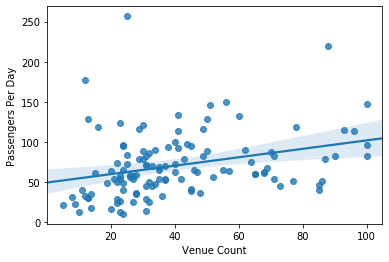

In [18]:
seaborn.regplot(fullData["Venue Count"], fullData["Passengers Per Day"])

We see a number of outliers and I think this relationship also requires our further research.

# 3. Regression analysis

### Regression analysis of "Distance To Center" and "RBC"

Let's try to predict the number of venue categories __RBC__ (__R__estaurant, __B__ar / Pub, __C__offee Shop) by the distance of the metro station to center. Firstly, look at linear regression.

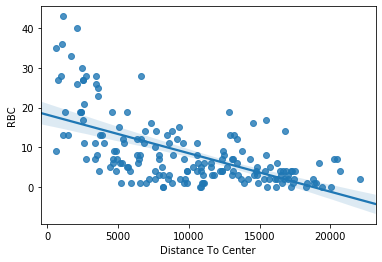

In [19]:
seaborn.regplot(fullData["Distance To Center"], fullData["RBC"])

Now, let's take a look at the residual plot.

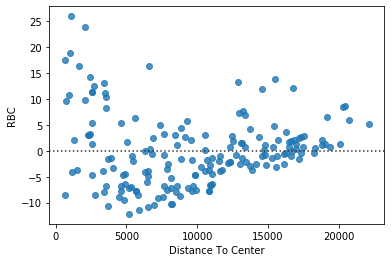

In [20]:
seaborn.residplot(fullData["Distance To Center"], fullData["RBC"])

As we can see the residual is especially noticeable on the left and on the right, most likely the dependence is non-linear. Let's see the second order relationship.

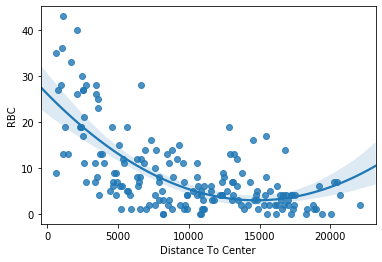

In [21]:
seaborn.regplot(fullData["Distance To Center"], fullData["RBC"], order=2)

It looks much better, but let's make calculations and check.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

fullDataCopy = fullData.copy()
fullDataCopy.set_index("Name", inplace=True)

x = fullDataCopy[["Distance To Center"]]
y = fullDataCopy["RBC"]

for i in range(1, 6):
    poly_reg = PolynomialFeatures(degree=i, include_bias=False)
    x_poly = poly_reg.fit_transform(x)

    lm = LinearRegression().fit(x_poly, y)
    r2 = lm.score(x_poly, y)
    print("Order = {}, R2 = {}".format(i, r2))


Order = 1, R2 = 0.36845034936441184
Order = 2, R2 = 0.4925077021548384
Order = 3, R2 = 0.5412731576692192
Order = 4, R2 = 0.5467736045217207
Order = 5, R2 = 0.5454578325751229


As you can see, order 3 is best suited. Further order increasing is not helpful.

(-1, 44)

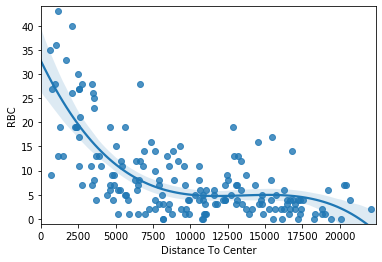

In [23]:
seaborn.regplot(fullData["Distance To Center"], fullData["RBC"], order=3)

plt.xlim([0, fullData["Distance To Center"].max()+300])
plt.ylim([-1, fullData["RBC"].max()+1])

Get the list of stations near which the number of venues of the RBC category is much smaller than what the model predicts.

In [24]:
poly_reg = PolynomialFeatures(degree=3, include_bias=False)
x_poly = poly_reg.fit_transform(x)

lm = LinearRegression().fit(x_poly, y)
#lm.intercept_

y_hat = lm.predict(x_poly)
y_diff = y_hat - y
y_diff.sort_values(inplace=True, ascending=False)
y_diff.head(20)

Name
Aleksandrovskiy sad, Biblioteka Imeni Lenina, Borovitskaya    19.782170
Kropotkinskaya                                                13.028021
Barrikadnaya, Krasnopresnenskaya                              11.538570
Polyanka                                                      11.221056
Krestyanskaya Zastava, Proletarskaya                          11.129983
Volgogradsky Prospekt                                          9.865675
Dostoyevskaya                                                  9.124027
Vorobyovy Gory                                                 8.347519
Chkalovskaya, Kurskaya                                         8.295212
Krasnoselskaya                                                 7.776191
Rizhskaya                                                      7.690707
Komsomolskaya                                                  7.624919
Fili                                                           7.204326
Butyrskaya                                                 

Get the top 20 stations worth further exploring for the people that want to open an RBC category business.

In [25]:
goodForRBC = y_diff[0:20].index.to_list()
goodForRBC 

['Aleksandrovskiy sad, Biblioteka Imeni Lenina, Borovitskaya',
 'Kropotkinskaya',
 'Barrikadnaya, Krasnopresnenskaya',
 'Polyanka',
 'Krestyanskaya Zastava, Proletarskaya',
 'Volgogradsky Prospekt',
 'Dostoyevskaya',
 'Vorobyovy Gory',
 'Chkalovskaya, Kurskaya',
 'Krasnoselskaya',
 'Rizhskaya',
 'Komsomolskaya',
 'Fili',
 'Butyrskaya',
 'Novokuznetskaya, Tretyakovskaya',
 'Studencheskaya',
 'Minskaya',
 'Fonvizinskaya',
 'Dinamo, Petrovsky Park',
 'Sportivnaya']

### Regression analysis of "Passengers Per Day" and "Venue Count"

Consider the graph of linear regression between __Passengers Per Day__ and __Venue Count__ again.

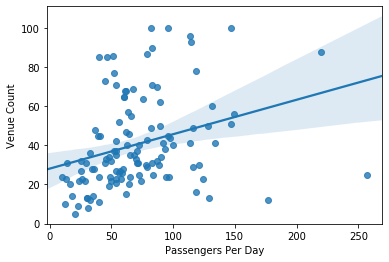

In [26]:
seaborn.regplot(x="Passengers Per Day", y="Venue Count", data=fullDataCopy)

In [27]:
fullDataCopy[['Passengers Per Day', 'Venue Count']].corr()

,Passengers Per Day,Venue Count
Passengers Per Day,1.000000,0.304615
Venue Count,0.304615,1.000000


Correlation = 0.3, which is very small. There is a number of outliers. Let's calculate them.

In [28]:
fullDataCopy.dropna(subset=["Passengers Per Day"], inplace=True)

x = fullDataCopy[["Venue Count"]]
y = fullDataCopy["Passengers Per Day"]

lm = LinearRegression().fit(x, y)

y_hat = lm.predict(x)
y_diff = y_hat - y
y_diff.sort_values(inplace=True)
y_diff.head(15)

Name
Komsomolskaya                           -194.106875
Chekhovskaya, Pushkinskaya, Tverskaya   -124.322163
Vykhino                                 -120.975291
Tushinskaya                              -72.601106
Park Kultury                             -70.688112
Chkalovskaya, Kurskaya                   -70.462041
VDNKh                                    -62.983900
Shchyolkovskaya                          -62.759247
Tekstilshchiki                           -61.090548
Rechnoy Vokzal                           -56.061945
Yugo-Zapadnaya                           -52.980227
Petrovsko-Razumovskaya                   -51.480131
Belorusskaya                             -50.829368
Kiyevskaya                               -45.077932
Novogireyevo                             -43.116900
Name: Passengers Per Day, dtype: float64

In this list we can see three stations near the railway stations of Moscow - __Komsomolskaya__, __Chkalovskaya, Kurskaya__, __Belorusskaya__. Obviously, the huge traffic at these stations is connected with the railway stations, and not with the fact that the people live or work there, which means that the number of venue should be less than for ordinary stations. The list also has the largest transport hubs. Moscow has a huge working intraday migration. Every day, millions of people from Moscow suburbs come to Moscow to work and return back in the evening. Therefore, a number of stations that are located on the outskirts of Moscow, or are located next to electric train platforms, are have huge passenger traffic. At the same time, people at these stations turn out to be in transit and do not create demand for venues in their vicinity. So I decided to drop these stations.

In [29]:
fullDataCopy.drop(["Komsomolskaya", "Chkalovskaya, Kurskaya", "Belorusskaya",
                   "Tushinskaya", "Vykhino", "Rechnoy Vokzal", "Shchyolkovskaya",
                   "Tekstilshchiki", "Petrovsko-Razumovskaya", "Yugo-Zapadnaya"
         ], inplace=True, errors='ignore')

In [30]:
fullDataCopy[['Passengers Per Day', 'Venue Count']].corr()

,Passengers Per Day,Venue Count
Passengers Per Day,1.000000,0.511996
Venue Count,0.511996,1.000000


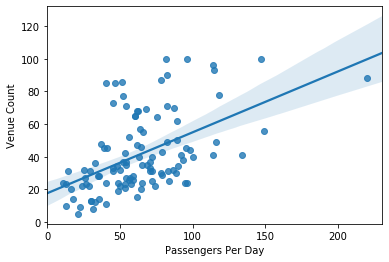

In [31]:
seaborn.regplot(x="Passengers Per Day", y="Venue Count", data=fullDataCopy)

Now the correlation is __0.51__, which is better than the initial 0.3, but still weak. I hypothesized that these two variables are more closely related, but this is not so.

# Results and Discussion

In this study, I managed to find only one strong dependence of the metro station parameters on the distance to the center of Moscow. Since Moscow has a circular structure, the distance to the center is a good characteristic for metro stations. Especially good the distance to the center correlates with the number of venues of category RBC (__R__estaurant, __B__ar / Pub, __C__offee Shop). The cubic regression between these variables is the main result of this study. If a businessman plans to open a new business of this category in Moscow near the metro station, he should first look at the stations from the __goodForRbc__ list. Because near these stations, the number of venue RBC categories is much less than the model predicts, which means that maybe they are not enough there. Let's look at the map. Stations from the __goodForRbc__ list are marked in red.

In [32]:
map_moscow = folium.Map(location=[latitudeMoscowCenter, longitudeMoscowCenter], zoom_start=10)

fullData['marker_color'] = 0
fullData.loc[fullData['Name'].isin(goodForRBC), 'marker_color'] = 1
#goodForRBC

# add markers to map
for lat, lng, name, col in zip(fullData['Latitude'], fullData['Longitude'], fullData['Name'], fullData['marker_color']):
    #label = '{}, {}'.format(name, ppd)
    label = name
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red' if col == 1 else 'green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_moscow)

folium.Circle(
    radius=3000,
    location=[latitudeMoscowCenter, longitudeMoscowCenter],
    popup='Moscow Center',
    color='red',
    fill=False,
).add_to(map_moscow)

map_moscow

In addition, you can see that the stations in the center are much deeper and older than those outside the center. This is logical, because initially the metro was built in the center and only then grew as the city grew. And the depth of the original stations in the center is due to the fact that they still had the function of bomb shelters.


# Conclusion

Purpose of this project was to identify metro stations in the vicinity of which it is better to open a new business in order to aid stakeholders in narrowing down the search for optimal location. I managed to find the cubic regression between the number of venues of category RBC (Restaurant, Bar / Pub, Coffee Shop) and the distance to the center. Stakeholders should use the list of metro stations based on this dependence.

Final decision on optimal location will be made by stakeholders based on specific characteristics of metro station, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics etc. It also seems to me to be useful to use the ratio between "Venue Count" and "Passengers Per Day".